#Instructions for running the code

##Option 1

Visualize ready-made results (recommended) on tensorboard and matplotlib.pyplot by running the line of code in the section 'Load results', after saving the folder net_results in the path:

- *gdrive/My Drive/*

##Option 2

To run the code from scratch:

Name the full zipped dataset Adaptiope.zip and save it in the gdrive path:

- *gdrive/My Drive/datasets/*

Put the file MMD_loss.py and the file tsne_torch.py in the path:

- *gdrive/My Drive/*

After the execution of the **Process Adaptiope** shell script, you can avoid running it again thus saving time, by commenting out such script; the output of this script is the reduced adaptiope dataset (Adaptiope_reduced.zip) and it is saved in the path:

- *gdrive/My Drive/datasets/*

Run the remaining chunks of code



#Deep learning project: Unsupervised Domain Adaptation on the Adaptiope dataset
**Author**: *Leonardo Golinelli* <br>
**Matricola**: *224160* <br>
**Course**: *Deep Learning* <br>
**Professor**: *Elisa Ricci* <br>
**Assistant**: *Giacomo Zara* <br>


##Introduction to the project
In this notebook, I implement an unsupervised domain adaptation (UDA) strategy on the Adaptiope dataset, inspired by the paper of Darrell et al. (2014): 'Deep Domain Confusion: Maximizing for Domain Invariance'. The code provided here is mainly a result of reworking code shown during in-class tutorials, original code, and code snippets taken from sources unrelated to the original paper.

##Context
The Adaptiope dataset contains images from 3 domains and 123 classes, but for simplicity it has been here reduced in order to contain 2 domains (real life and product) and 20 classes.
The keypoint is that in the real world we often have a limited amount of labeled images, because labeling consumes a lot of resources (time, people..).
That's why in order to perform automatic image classification models should be able to leverage both supervised and unsupervised information available.
An effective strategy is one that leads to an increase in accuracy in predicting images when including unsupervised data in the learning.

Another problem is that often images come from different distributions, hence prior to classification we want to be able to map the input data in a feature space that is domain invariant.

This is the problem of unsupervised domain adaptation.

##Strategy
In the paper by Darrell et al. mentioned before, autors use AlexNet (A. Krizhevsky et. al 2012) as a backbone architecture with pretrained weights in order to extract features from both domains.
In the classification layer, they apply a loss to the distance between the features of the 2 distributions, called Maximum Mean Discrepancy (MMD) (Gretton et al, JMLRS), while keeping at the same time a Cross Entropy Loss on the data coming from the source distribution (the one for which labels are available).
This allows to leverage supervised and unsupervised data at the same time to hopefully obtain a better model.

In the paper, the loss is computed with respect to the output of only a single fully connected layer, which they call the 'bottleneck layer', because they reduced its dimensionality (from 4096 to 256), or 'adapation layer'. 
By reducing the dimensionality, they hope that this will act as a regularizer, in the sense that domain-specific features will be lost or diluted prior to classification by passing through this layer (in conjunction with the MMD distance loss).

I firstly tried to replicate exactly this strategy on the Adaptiope dataset(without looking at the original github code):
I reduced the dimensionality of the second FC layer to create a bottleneck effect, and I applied the MMD loss to the output of only the bottleneck layer with a relatively low weight of 0.25, while keeping the cross entropy loss on the final output of AlexNet for the supervised images (weight = 1). Autors provided an explanation for the 0.25 weight by saying that it is sufficiently low to take into account the unsupervised data, but not too high to disrupt classification.

By doing some tests, I discovered that I could improve test accuracy of the model by:

- Removing the bottleneck layer. My explanation is that, while the idea of having a bottleneck is good for domain adaptation, reducing the dimensionality of the intermediate fully connected layer leads to loss of the weights pretrained on imagenet for such layer, thereby reducing to a significant extent absolute performance.

- Instead of applying the MMD distance loss to only one layer at a weight of 0.25, it is better to apply such loss to the output of each FC layer, each with a weight of 1. This leads to stronger and more visible effect in the extra gain from unsupervised data, as the source and target distributions get closer in feature space.

- Unsupervised images go through all the FC layers, instead of stopping at the adaptation layer (this allows to compute the MMD distance also for the outputs of the last layer).


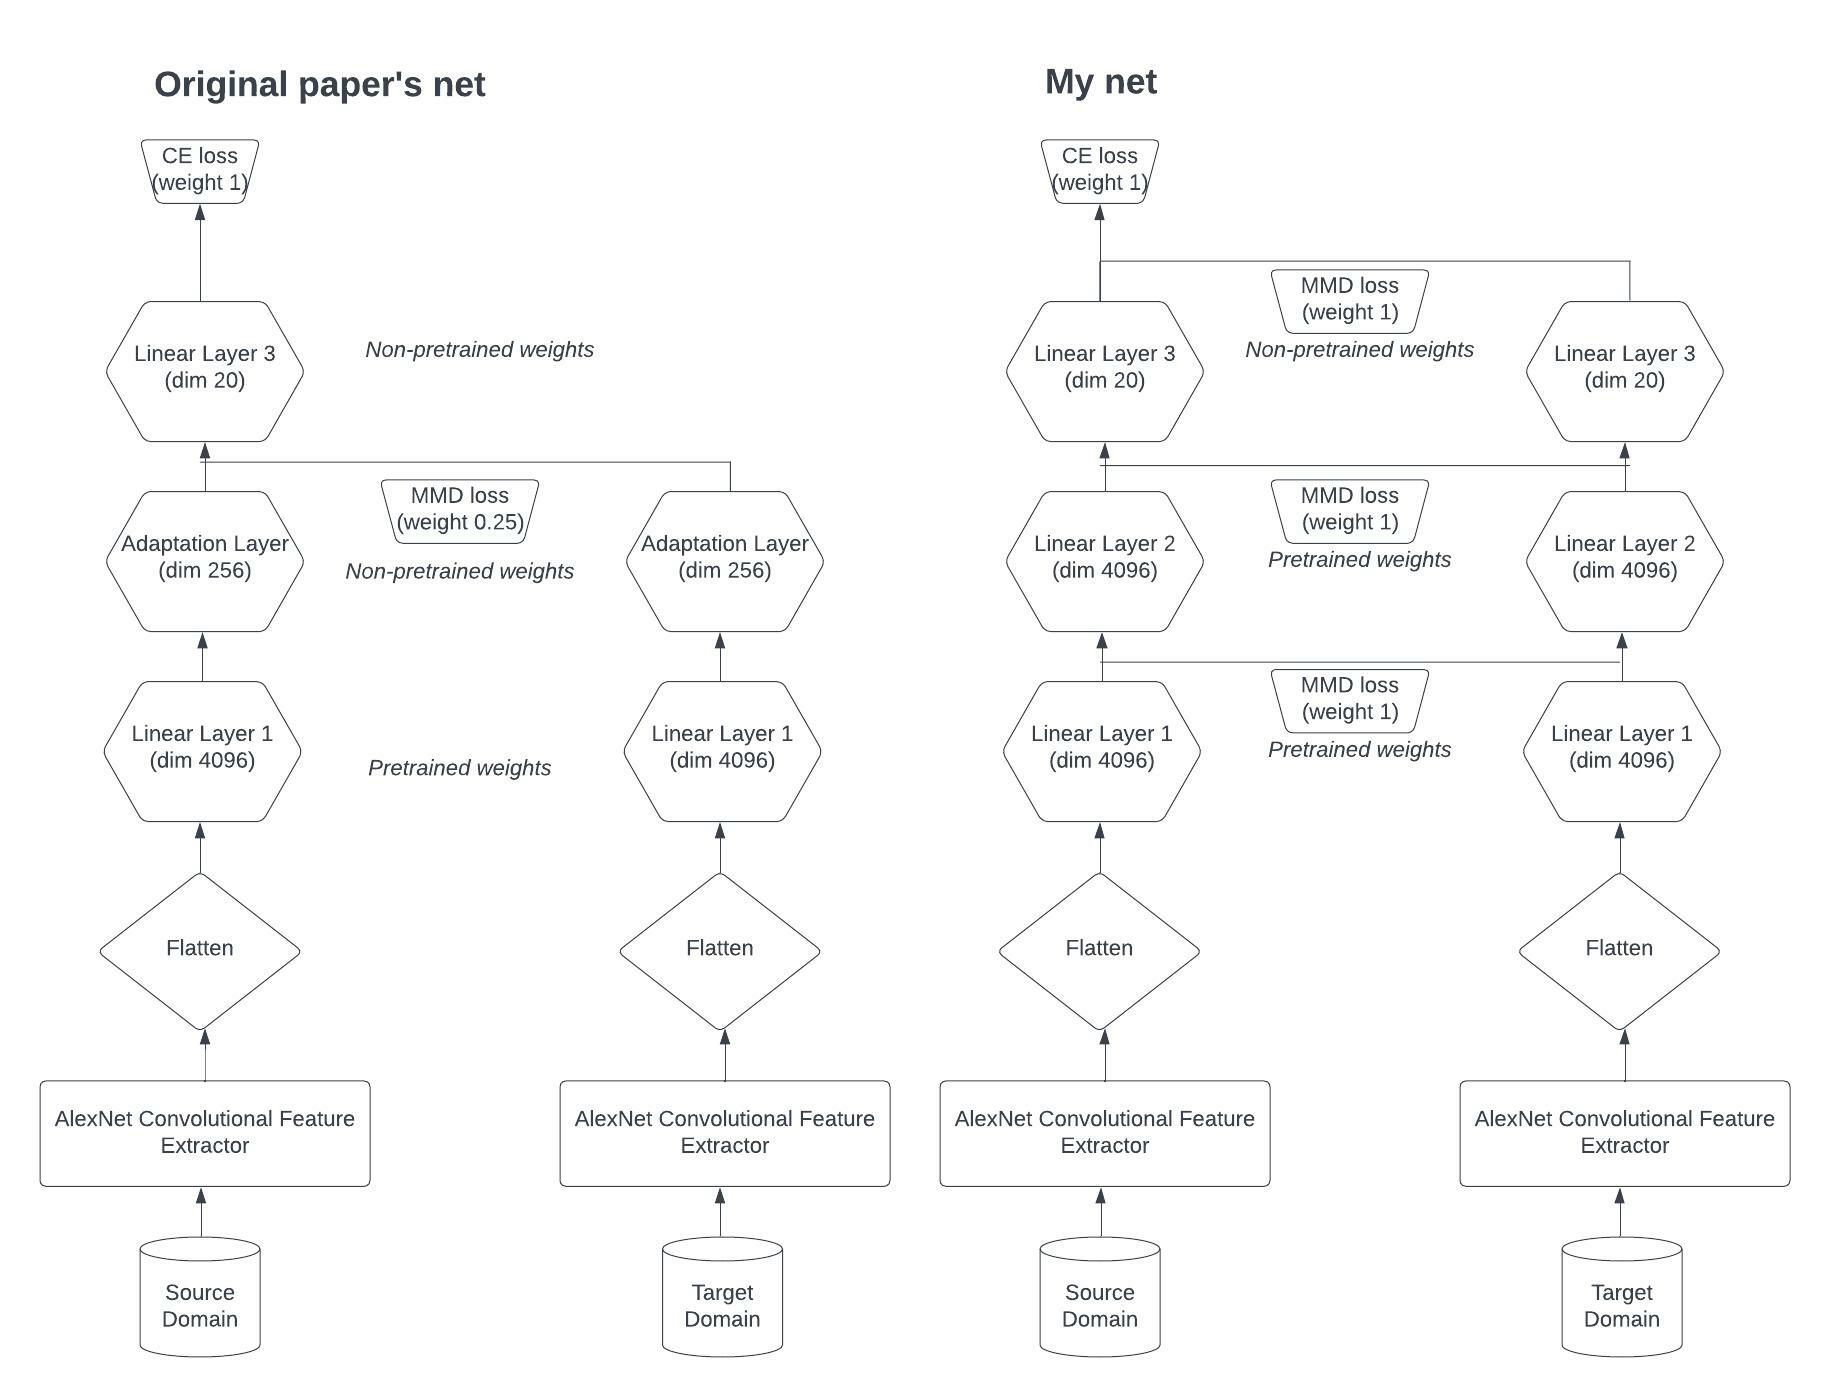

Apart from the linear layers, this implementation of AlexNet provided by PyTorch contains a module that I called Convolutional Feature extractor, and contains 5 convolutional layers with a ReLU activation function and Max Pooling, and it ends with an average pooling.
The first 2 linear layers use dropout regularization.

https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py



##Connect to gdrive

In [ ]:
#Set up connection to google drive, where the Adaptiope Dataset lies
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

##Process Adaptiope

The following code can be used to produce the reduced version of the Adaptiope dataset and save such version on the Drive.

This code should be commented out after the first execution to make code execution globally faster when one wants to perform multiple runs.

In [ ]:
%%shell

cp "gdrive/My Drive/datasets/Adaptiope.zip" .  #copy Adaptiope full in colab local
unzip Adaptiope.zip
rm -r Adaptiope.zip Adaptiope/synthetic #remove the synthetic domain

#finds all folders for the classes of interest and removes the remaining ones

for f in Adaptiope/*; do
  parent_folder_name=$(echo $f | awk -F/ '{print $NF}')
  #echo $parent_folder_name
  find $f -maxdepth 1 ! -name $parent_folder_name ! -name backpack ! -name bookcase ! -name car\ jack ! -name comb ! -name crown \
  ! -name file\ cabinet ! -name flat\ iron ! -name game\ controller ! -name \glasses ! -name helicopter ! -name ice\ skates \
  ! -name letter\ tray ! -name monitor ! -name mug ! -name network\ switch ! -name over-ear\ headphones ! -name pen ! -name pen \
  ! -name purse ! -name stand\ mixer ! -name stroller -exec rm -rv {} \;
done

#zips the reduced dataset and saves it on the drive
zip "gdrive/My Drive/datasets/Adaptiope_reduced.zip" -r Adaptiope/
rm -r Adaptiope/

##Load reduced dataset, mmd loss, and tsne pytorch from gdrive

In [ ]:
#loads the reduced dataset and two modules: a github implementation of the MMD loss and another implementation for TSNE in pytorch

%%shell
cp 'gdrive/My Drive/datasets/Adaptiope_reduced.zip' .
unzip -qq Adaptiope_reduced.zip
rm -r Adaptiope_reduced.zip
#copies the MMD_loss module to local
cp gdrive/MyDrive/loss_MMD.py .
#copies modified code for tsne visualization
cp -r gdrive/MyDrive/tsne_torch.py . 

##Import libraries and modules

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import alexnet, AlexNet_Weights
import numpy as np
from tsne_torch import TorchTSNE as TSNE
from loss_MMD import MMD_loss
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from pathlib import Path
from PIL import Image

##Load and transform data

Images were resized, randomly cropped, and normalized prior to be fed to the network.

In [ ]:
def get_data(batch_size, source = 'real', target = 'product'):

  # prepare data transformations 
  transform = list()
  transform.append(T.Resize((256, 256)))                      # resize each PIL image to 256 x 256
  transform.append(T.RandomCrop((224, 224)))                  # randomly crop a 224 x 224 patch
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]))    # normalize with ImageNet mean
  transform = T.Compose(transform)                            # compose the above transformations into one
  
  #decides which domain is source and which is product, based on user input
  if source == 'real' and target == 'product':
    source_path = 'Adaptiope/real_life/'
    target_path = 'Adaptiope/product_images/'
  elif source == 'product' and target == 'real':
    source_path = 'Adaptiope/product_images/'
    target_path = 'Adaptiope/real_life/'
  else:
    raise ValueError('Source should be \'real\' and target should be \'product\' or viceversa')

  # load data
  source_dataset = torchvision.datasets.ImageFolder(source_path, transform = transform)
  target_dataset = torchvision.datasets.ImageFolder(target_path, transform = transform)

  # create train and test splitst (80/20)
  num_samples = len(source_dataset) #same length as the target dataset
  training_samples = int(num_samples * 0.8)
  test_samples = num_samples - training_samples

  #random split of source and target dataset. 
  #test set for the source dataset is not used in training, but only for visualization purposes
  train_source, test_source = torch.utils.data.random_split(source_dataset, #test_source is just used for TSNE
                                                          [training_samples, test_samples])  
  train_target, test_target = torch.utils.data.random_split(target_dataset, 
                                                          [training_samples, test_samples])

  # initialize source train and test dataloaders
  source_train_loader = torch.utils.data.DataLoader(train_source, batch_size, shuffle=True)
  source_test_loader = torch.utils.data.DataLoader(test_source, batch_size, shuffle=True, drop_last = True) 
  #source test data is not used in training, but in TSNE visualization along with target test data

  #initialize target training and test dataloaders
  target_train_loader = torch.utils.data.DataLoader(train_target, batch_size, shuffle=True)
  target_test_loader = torch.utils.data.DataLoader(test_target, batch_size, shuffle=True, drop_last = True)
  
  return source_train_loader, source_test_loader, target_train_loader, target_test_loader

##Initialize AlexNet with pretrained weights

In [ ]:
#All default weights are kept, except for the last layer which is re-initialized to have an output dimension of 20
def initialize_alexnet():
  weights = AlexNet_Weights.DEFAULT #weights
  # load the pre-trained Alexnet
  model = alexnet(weights = weights)
  model.classifier[-1] = nn.Linear(in_features=4096, out_features=20) #reinitialize last fc layer
  return model

##Maximum Mean Discrepancy (MMD distance)

As a strategy for aligning the source and target distributions, autors of the original paper used an approximation of the MMD distance.
Maximum mean discrepancy (MMD) is a kernel based statistical test used to determine whether given two distribution are the same, and it can be used as a loss/cost function in various machine learning algorithms.


A possible formal definition states that:
- Given two random variables X and Y, with probability distributions P and Q, the Maximum Mean Discrepancy is the distance (difference) between feature means of X, Y.

$$MMD^{2}(P,Q) = ||\mu_{p}-\mu_{q}||^{2}$$


Taken from: https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html.

The correct way to implement this statement mathematically is cumbersome, hence I looked for a ready-made implementation on github (https://github.com/ZongxianLee/MMD_Loss.Pytorch).

Note: I performed a minor modification on the code to avoid an index error that would come up during execution.

##Total loss of the model
The batchwise loss used in this model is a linear combination of cross entropy loss computed w.r.t. the supervised data, and the MMD losses computed w.r.t. the outputs of the three fully connected layers.

$$\text{Total loss} = \text{Cross Entropy} + \text{MMD distance weight} * (MMD_{fc1} + MMD_{fc2} + MMD_{fc3})$$

Better results were obtained by keeping the weight of the CE loss and the weight of MMDs at 1. Differential weight for the different FC layers was not explored.

##Initialize cost functions

In [ ]:
#initialize cross entropy loss for the supervised data and mmd_distance between fc layer outputs
def get_ce_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

def mmd_distance():
  mmd_distance = MMD_loss() 
  return mmd_distance

##Optimizer initialization
Code taken from in-class tutorial on fine tuning AlexNet.

Since other optimizers (i.e. Adam) did not perform significantly better than SGD with momentum, I decided to keep the latter.

The last layer is assigned a learning rate increased by a factor of 10, as the weights for such layer are not pretrained.


In [ ]:
def get_optimizer(model, lr, wd, momentum):
  
  # we will create two groups of weights, one for the newly initialized layer
  # and the other for rest of the layers of the network
  
  final_layer_weights = []
  rest_of_the_net_weights = []
  
  # iterate through the layers of the network
  for name, param in model.named_parameters():
    if name.startswith("classifier.6"):
      final_layer_weights.append(param)
    else:
      rest_of_the_net_weights.append(param)
  
  # assign the distinct learning rates to each group of parameters
  optimizer = torch.optim.SGD([
      {'params': rest_of_the_net_weights},
      {'params': final_layer_weights, 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)

  return optimizer

##Forward hooks

In order to extract outputs from internal layers, I used forward hooks.
These are stored in a dictionary and can be retrieved after the forward method is called.
Forward hooks allowed me to compute the MMD distance for the internal fully connected layers, and to create visual representations, without having to modify the 'forward' method in the AlexNet specification.

In [ ]:
def get_features(name, dic):
  def activation_hook(inst, inp, out):
        """Run activation hook.
        Parameters
        ----------
        inst : torch.nn.Module
            The layer we want to attach the hook to.
        inp : tuple of torch.Tensor
            The input to the `forward` method.
        out : torch.Tensor
            The output of the `forward` method.
        """
        dic[name] = out
  return activation_hook

##Train the network for domain adaptation or lower bound

In [ ]:
def training_step(net, source_dataloader, target_dataloader, optimizer, ce_cost_function, mmd_distance,
                  mmd_distance_weight, device='cuda'):

  source_samples = 0.
  target_samples = 0.
  cumulative_ce_loss = 0.
  cumulative_mmd_distance = 0.
  cumulative_accuracy = 0.

  activation = {} #dictionary that will store outputs of the ReLU activations for the first and second FC layers

  #register the forward hooks of interest and create handles
  handle_linear_1 = net.classifier[2].register_forward_hook(get_features('linear1', activation))
  handle_linear_2 = net.classifier[5].register_forward_hook(get_features('linear2', activation))

  target_iter = iter(target_dataloader)

  # set the network to training mode.
  net.train()

  # iterate over the training set
  for batch_idx, (inputs_source, labels) in enumerate(source_dataloader):

    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, _ = next(target_iter) #target labels are not used in the training step, hence they are not saved
    except:
      target_iter = iter(target_dataloader)
      inputs_target, _ = next(target_iter)


    # load data into GPU
    inputs_source = inputs_source.to(device)
    labels = labels.to(device)
    inputs_target = inputs_target.to(device)

    # forward pass

    inputs = torch.cat((inputs_source, inputs_target), dim=0) 
    #source and target inputs are concatenated just to improve order and decrease code redundancy.
    #moreover, batch normalization is NOT used in this architecture

    # forward pass
    outputs = net(inputs)

    #retrieve model outputs for the first and second linear layers (a hook is not needed for the last (third) layer )
    out_linear_1 = activation['linear1']
    out_linear_2 = activation['linear2']
    
    # split the source and target outputs
    out_linear_1_source, out_linear_1_target = torch.split(out_linear_1, split_size_or_sections=outputs.shape[0] // 2, dim=0)
    out_linear_2_source, out_linear_2_target = torch.split(out_linear_2, split_size_or_sections=outputs.shape[0] // 2, dim=0)
    net_out_source, net_out_target = torch.split(outputs, split_size_or_sections=outputs.shape[0] // 2, dim=0)

    #compute losses
    ce_loss = ce_cost_function(net_out_source,labels)

    #compute mmd distances between source and target outputs for first, second, and third linear layers
    mmd_linear1 = mmd_distance(out_linear_1_source, out_linear_1_target)
    mmd_linear2 = mmd_distance(out_linear_2_source, out_linear_2_target)
    mmd_out = mmd_distance(net_out_source, net_out_target)

    #compute total mmd as the sum of individual mmds
    mmd = mmd_linear1 + mmd_linear2 + mmd_out

    #compute total loss as the sum of ce loss and total mmd
    #for simplicity, I only used one weight to multiply all mmd distances
    loss = ce_loss + mmd_distance_weight * mmd 

    # backward pass
    loss.backward()
    
    # parameters update
    optimizer.step()
    
    # gradients reset
    optimizer.zero_grad()

    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    cumulative_ce_loss += ce_loss.item()
    cumulative_mmd_distance += mmd.item()
    total_loss = cumulative_ce_loss + cumulative_mmd_distance
    _, predicted = net_out_source.max(1)
    cumulative_accuracy += predicted.eq(labels).sum().item()

  return cumulative_ce_loss/source_samples, cumulative_mmd_distance/target_samples, total_loss, cumulative_accuracy/source_samples*100

##Test the network

The following test step performs multiple things:

- Loads test samples from both source and target domain.
- Computes test accuracy on the target domain
- Retrieves outputs from all FC layers through forward hooks and computes the total MMD distance between source and target domain.
- Apart from statistics, returns outputs and labels from the second FC layer for visualization.




In [ ]:
def test_step(net, source_dataloader, target_dataloader, ce_cost_function, mmd_distance, plot_layer, device='cuda'):


  source_samples = 0.
  target_samples = 0.
  ce_cumulative_loss = 0.
  cumulative_accuracy = 0.
  cumulative_mmd_distance = 0.

  activation = {} #dictionary that will store outputs of the ReLU activations for the first and second FC layers

  #register forward hooks
  handle_linear_1 = net.classifier[2].register_forward_hook(get_features('linear1', activation))
  handle_linear_2 = net.classifier[5].register_forward_hook(get_features('linear2', activation))

  source_iter = iter(source_dataloader)

  # set the network to evaluation mode
  net.eval() 

  # disable gradient computation
  with torch.no_grad():

    # iterate over the test set
    for batch_idx, (inputs_target, labels_target) in enumerate(target_dataloader):

      # get source data. If the target iterator reaches the end, restart it
      try:
        inputs_source, labels_source = next(source_iter)
      except:
        source_iter = iter(source_dataloader)
        inputs_source, labels_source = next(source_iter)

      # load data into GPU
      inputs_source = inputs_source.to(device)
      inputs_target = inputs_target.to(device)
      labels_source = labels_source.to(device)
      labels_target = labels_target.to(device)

      inputs = torch.cat((inputs_source, inputs_target), dim=0) 
      #source and target inputs are concatenated just to improve order and decrease code redundancy.
      #moreover, batch normalization is NOT used in this architecture

      # forward pass
      outputs = net(inputs)

      #retrieve model outputs for the first and second linear layers
      out_linear_1 = activation['linear1']
      out_linear_2 = activation['linear2']

      # split the source and target labels_target and outputs
      out_linear_1_source, out_linear_1_target = torch.split(out_linear_1, split_size_or_sections=outputs.shape[0] // 2, dim=0)
      out_linear_2_source, out_linear_2_target = torch.split(out_linear_2, split_size_or_sections=outputs.shape[0] // 2, dim=0)
      net_out_source, net_out_target = torch.split(outputs, split_size_or_sections=outputs.shape[0] // 2, dim=0)

      # compute losses
      ce_loss = ce_cost_function(net_out_source,labels_target)

      #compute mmd distances between source and target outputs for first, second, and third linear layers
      mmd_linear1 = mmd_distance(out_linear_1_source, out_linear_1_target)
      mmd_linear2 = mmd_distance(out_linear_2_source, out_linear_2_target)
      mmd_out = mmd_distance(net_out_source, net_out_target)
      mmd = mmd_linear1 + mmd_linear2 + mmd_out

      #fetch prediction and loss value
      source_samples+=inputs_source.shape[0]
      target_samples+=inputs_target.shape[0]
      ce_cumulative_loss += ce_loss.item() # Note: the .item() is needed to extract scalars from tensors
      cumulative_mmd_distance += mmd.item()
      total_loss = ce_cumulative_loss + cumulative_mmd_distance
      _, predicted = net_out_target.max(1)

      #compute accuracy
      cumulative_accuracy += predicted.eq(labels_target).sum().item()      

  return ce_cumulative_loss/target_samples, cumulative_accuracy/target_samples*100, cumulative_mmd_distance/target_samples, total_loss, out_linear_2, labels_source, labels_target

##Train the network to find the upper bound

In order to identify the architecture's upper bound, the model is allowed to make use of labeled data for the target domain also. Ideally, the best UDA strategy will lead to an UDA test accuracy very similar to the upper bound test accuracy. The MMD computed here is just used to get information on the distance between distributions, and it is not used in the training step.

In [ ]:
def training_step_upper_bound(net, source_dataloader, target_dataloader, optimizer, ce_cost_function, mmd_distance, device='cuda'): #target labels are included

  source_samples = 0.
  target_samples = 0.
  total_samples = 0.
  cumulative_ce_loss_source = 0.
  cumulative_ce_loss_target = 0.
  total_ce_loss = 0.
  cumulative_mmd_distance = 0.
  cumulative_accuracy_source = 0.
  cumulative_accuracy_target = 0.
  total_accuracy = 0.

  activation = {}  #dictionary that will store outputs of the ReLU activations for the first and second FC layers

  handle_linear_1 = net.classifier[2].register_forward_hook(get_features('linear1', activation))
  handle_linear_2 = net.classifier[5].register_forward_hook(get_features('linear2', activation))

  target_iter = iter(target_dataloader)

  # set the network to training mode: particularly important when using dropout!
  net.train()

  # iterate over the training set
  for batch_idx, (inputs_source, labels_source) in enumerate(source_dataloader):

    # get target data. If the target iterator reaches the end, restart it
    try:
      inputs_target, labels_target = next(target_iter)
    except:
      target_iter = iter(target_dataloader)
      inputs_target, labels_target = next(target_iter)

    # load data into GPU
    inputs = torch.cat((inputs_source, inputs_target), dim=0)
    #source and target inputs are concatenated just to improve order and decrease code redundancy.
    #moreover, batch normalization is NOT used in this architecture


    inputs = inputs.to(device)
    labels_source = labels_source.to(device)
    labels_target = labels_target.to(device)

    # forward pass
    outputs = net(inputs)

    #retrieve model outputs for the first and second linear layers
    out_linear_1 = activation['linear1']
    out_linear_2 = activation['linear2']

    # split the source and target labels_target and outputs
    out_linear_1_source, out_linear_1_target = torch.split(out_linear_1, split_size_or_sections=outputs.shape[0] // 2, dim=0)
    out_linear_2_source, out_linear_2_target = torch.split(out_linear_2, split_size_or_sections=outputs.shape[0] // 2, dim=0)
    net_out_source, net_out_target = torch.split(outputs, split_size_or_sections=outputs.shape[0] // 2, dim=0)

    # compute the losses
    ce_loss_source = ce_cost_function(net_out_source,labels_source)
    ce_loss_target = ce_cost_function(net_out_target,labels_target)

    #compute mmd distances between source and target outputs for first, second, and third linear layers.
    mmd_linear1 = mmd_distance(out_linear_1_source, out_linear_1_target)
    mmd_linear2 = mmd_distance(out_linear_2_source, out_linear_2_target)
    mmd_out = mmd_distance(net_out_source, net_out_target)
    mmd = mmd_linear1 + mmd_linear2 + mmd_out
    
    loss = ce_loss_source + ce_loss_target #notice that mmd is not used during training in this loss.
    
    # backward pass
    loss.backward()
    
    # parameters update
    optimizer.step()
    
    # gradients reset
    optimizer.zero_grad()

    # print statistics
    source_samples+=inputs_source.shape[0]
    target_samples+=inputs_target.shape[0]
    total_samples+= source_samples + target_samples
    
    cumulative_ce_loss_source += ce_loss_source.item()
    cumulative_ce_loss_target += ce_loss_target.item()
    #total_ce_loss += cumulative_ce_loss_source + cumulative_ce_loss_target
    cumulative_mmd_distance += mmd.item()
    #total_loss = total_ce_loss + cumulative_mmd_distance
    _, predicted_source = net_out_source.max(1)
    _, predicted_target = net_out_target.max(1)
    cumulative_accuracy_source += predicted_source.eq(labels_source).sum().item()
    cumulative_accuracy_target += predicted_target.eq(labels_target).sum().item()
    total_accuracy += cumulative_accuracy_source + cumulative_accuracy_target

  return (cumulative_ce_loss_source/source_samples, cumulative_ce_loss_target/target_samples,# total_ce_loss/total_samples,
            cumulative_accuracy_source/source_samples, cumulative_accuracy_target/target_samples, total_accuracy/total_samples,
            cumulative_mmd_distance/source_samples)

##Plot TSNE

As an excercise, and in trying to follow what the authors did, I wanted to visualize the output of a hidden layer, namely the second last fully connected layer. Since the hidden layer mentioned has 4096 dimensions, such features need to be converted in 2 dimensions in a nonlinear fashion, by respecting as much as possible distances between the datapoints in the original feature space.
This is done through a pytorch implementation of TSNE https://pypi.org/project/tsne-torch/ .
Using forward hooks and dimensionality reduction, any inner layer's output can be potentially visualized.

In [ ]:
def plot_2d_representation(inputs, source_labels, target_labels, image_dir, epoch):

  #inputs are provided from the test step as a single tensor with 50% source and 50% test observations
  #I found that inputs need to be normalized prior TSNE computation to avoid warnings \ blank plots
  tsne_inputs = F.normalize(inputs, p=2.0, dim=1)

  #compute dimensionality reduction with torch TSNE
  tsne_output = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=False).fit_transform(tsne_inputs)
  #split TSNE output in source and target
  source_tsne_output, target_tsne_output = torch.split(torch.Tensor(tsne_output), split_size_or_sections=tsne_output.shape[0] // 2, dim=0)

  #get x and y coordinates of source and target tsne outputs
  x_source = [row[0] for row in source_tsne_output]
  y_source = [row[1] for row in source_tsne_output]
  x_target = [row[0] for row in target_tsne_output]
  y_target = [row[1] for row in target_tsne_output]

  #bring labels into cpu
  source_labels = source_labels.cpu()
  target_labels = target_labels.cpu()

  #subplot tsne outputs, with domain being marker shape, and class being the colour
  plt.figure(figsize=(14,14)) 
  plt.scatter(x_source, y_source, c=source_labels, marker="X", s=100, cmap='tab20')
  plt.scatter(x_target, y_target, c=target_labels, marker="s", s=100, cmap='tab20')
  plt.savefig(fname=image_dir+"tsne_epoch"+str(epoch+1)+".jpg")
  plt.legend(["source" , "target"], loc= 'upper right',)
  
  plt.show()


##Run the net for the upper bound

In [ ]:
def get_upper_bound(batch_size=128, 
                device='cuda:0', 
                learning_rate=0.001, 
                weight_decay=0.000001, 
                momentum=0.9, 
                epochs=50, 
                num_classes=20, 
                source='real', #set to either 'product' or 'real'
                target='product', #set to either 'product' or 'real'
                plot_tsne = True, #if true, the test output of the second fc layer is plotted after tsne dimensionality reduction
                log_dir = 'net_results/real_to_product/summary_writer/upper_bound/', #directory for summarywriter logs
                image_dir='net_results/real_to_product/tsne_images/upper_bound/'): #drive directory for pyplot tsne plots

  #check if log and image directories and their parents are present and if not, create them
  for dir in log_dir, image_dir:
    Path(dir).mkdir(parents=True, exist_ok=True) 

  writer = SummaryWriter(log_dir=log_dir)

  # instantiates dataloaders
  source_train_loader, source_test_loader, target_train_loader, target_test_loader = get_data(batch_size, source=source,
                                                                          target=target)
  # instantiates the model

  net = initialize_alexnet().to(device)


  # instantiates the optimizer
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  # instantiates the cost function
  ce_cost_function = get_ce_cost_function()
  mmd_loss = mmd_distance()


  # training step upper bound
  for e in range(epochs):
    (train_ce_loss_source, train_ce_loss_target,
    train_accuracy_source, train_accuracy_target, train_total_accuracy,
    train_mmd) = training_step_upper_bound(net=net, source_dataloader=source_train_loader, target_dataloader=target_train_loader, optimizer=optimizer,ce_cost_function=ce_cost_function,
                                           mmd_distance=mmd_loss, device=device)

    #training step                                 
    (test_ce_loss, test_accuracy, test_mmd,
     test_total_loss, fc2_output, source_labels, target_labels) = test_step(net, source_test_loader, target_test_loader, ce_cost_function, mmd_loss, device)


    #print statistics
    print('Epoch: {:d}'.format(e+1))
    print('\t Train: Source CE loss: {:.5f}, Target CE loss: {:.5f}, MMD: {:5f}'.format(train_ce_loss_source, train_ce_loss_target, train_mmd))
                                                                                                                                    
                                                                                                                                   
    
    print('\t Train: Source accuracy: {:.5f}, Target accuracy: {:.5f}, Total accuracy: {:.5f}'.format(train_accuracy_source, train_accuracy_target, 
                                                                                            train_total_accuracy))
    
    print('\t Test: CE loss {:.5f}, MMD_loss {:.5f}, Accuracy {:.2f}'.format(test_ce_loss, test_mmd, test_accuracy))
    print('-----------------------------------------------------')


    # add values to logger
    writer.add_scalar('Source_train/train_ce_loss_source', train_ce_loss_source, e + 1)
    writer.add_scalar('Source_train/train_accuracy_source', train_accuracy_source, e + 1)
    writer.add_scalar('Target_train/train_ce_loss_target', train_ce_loss_target, e + 1)
    writer.add_scalar('Target_train/train_accuracy_target', train_accuracy_target, e + 1)
    writer.add_scalar('Global_train/train_total_accuracy', train_total_accuracy, e + 1)
    writer.add_scalar('Global_train/train_mmd', train_mmd, e + 1)
    writer.add_scalar('Test/test_accuracy', test_accuracy, e + 1)
    writer.add_scalar('Test/test_ce_loss', test_ce_loss, e + 1)
    writer.add_scalar('Test/test_mmd', test_mmd, e + 1)


    if plot_tsne:
      plot_2d_representation(inputs = fc2_output,
                             source_labels=source_labels,target_labels=target_labels,
                             image_dir=image_dir,epoch=e)
    
    print("-------------------------------------------------------")

##Run the net for lower bound or domain adaptation

The function 'main' trains the network for UDA if the weight of the mmd distance is greater than zero.
If such weight equals zero the unsupervised data will not be used in training (this corresponds to the lower bound).

In [ ]:
def main(batch_size=128, 
         device='cuda:0', 
         learning_rate=0.001, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50, 
         num_classes=20, 
         source='real', #set to either 'product' or 'real'
         target='product', #set to either 'product' or 'real'
         mmd_distance_weight = 1,
         plot_tsne = True, #if true, the test output of the second fc layer is plotted after tsne dimensionality reduction
         log_dir='net_results/real_to_product/summary_writer/UDA',
         image_dir='net_results/real_to_product/tsne_images/UDA/'):
  
  for dir in log_dir, image_dir:
    Path(dir).mkdir(parents=True, exist_ok=True) #creates nested directories. if they already exist, directories are not created

  writer = SummaryWriter(log_dir=log_dir)

  # instantiates dataloaders
  source_train_loader, source_test_loader, target_train_loader, target_test_loader = get_data(batch_size, source=source,
                                                                          target=target)
  # instantiates the model
  net = initialize_alexnet().to(device)
  
  # instantiates the optimizer
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  # instantiates the cost function
  ce_cost_function = get_ce_cost_function()
  mmd_loss = mmd_distance()

  # training step for UDA or lower bound (depending on mmd_distance_weight)
  for e in range(epochs):
    train_ce_loss, train_mmd_loss, train_total_loss, train_accuracy = training_step(net=net, source_dataloader=source_train_loader, 
                                                                  target_dataloader=target_train_loader, 
                                                                  optimizer=optimizer, ce_cost_function=ce_cost_function, mmd_distance=mmd_loss, 
                                                                  mmd_distance_weight=mmd_distance_weight, device=device)
    
    #test step
    (test_ce_loss, test_accuracy, test_mmd,
     test_total_loss, fc2_output, source_labels, target_labels) = test_step(net, source_test_loader, target_test_loader, ce_cost_function, mmd_loss, device)

    print('Epoch: {:d}'.format(e+1))
    print('\t Train: CE loss {:.5f}, MMD loss {:.5f}, Total loss {:.5f}, Accuracy {:.2f}'.format(train_ce_loss, train_mmd_loss, train_total_loss, train_accuracy))
    print('\t Test: CE loss {:.5f}, MMD_loss {:.5f}, Accuracy {:.2f}'.format(test_ce_loss, test_mmd, test_accuracy))

    # add values to logger
    writer.add_scalar('Accuracy/train_accuracy', train_accuracy, e + 1)
    writer.add_scalar('Accuracy/test_accuracy', test_accuracy, e + 1)
    writer.add_scalar('Loss/train_ce_loss', train_ce_loss, e + 1)
    writer.add_scalar('Loss/train_mmd_loss', train_mmd_loss, e + 1)
    writer.add_scalar('Loss/train_total_loss', train_total_loss, e + 1)
    writer.add_scalar('Loss/test_mmd_loss', test_mmd, e + 1)
    writer.add_scalar('Loss/ce_test_loss', test_ce_loss, e + 1)
    writer.add_scalar('Loss/total_loss_test', test_total_loss, e + 1)

    if plot_tsne:
      plot_2d_representation(inputs = fc2_output,
                             source_labels=source_labels,target_labels=target_labels,
                             image_dir=image_dir,epoch=e)
    
    print("-------------------------------------------------------")


#Results

##Log

Network performance (lower bound, upper bound, UDA) was measured in both directions:

product domain -> real life domain

real life domain -> product domain

Below, test accuracies at epoch 30 for different directions and frameworks of the network.

\begin{array}{|c|c|} \hline
 & product \rightarrow real & real \rightarrow product \\ \hline
lower & 60.42 & 79.23 \\
UDA & 67.11 & 85.60 \\
upper & 82.45 & 94.37 \\ \hline
\end{array}

I found that the harder direction was going from the product domain, in which objects are surrounded by a blank background, to the real life domain, which represented objects in a real life background.

The reason being of this discrepancy is most likely that, objects with no background are easier to classify then objects with a background.
Moreover, training on objects with no background will likely limit the ability of the network to distinguish the noise of the background from the real image.

\begin{array}{|c|c|} \hline
 & product \rightarrow real & real \rightarrow product \\ \hline
gain & +6.69 & +6.37 \\
missing & -15.34 & -8.77 \\ \hline
\end{array}

Based on the 30th epoch, the effect of the UDA strategy with respect to the baseline was visible in both directions, and led to a similar gain in accuracy between 6% and 7%. The similarity between the gains is encouraging, suggesting that the extra information gained through the unsupervised learning strategy used is somewhat invariant with respect to the direction.

The missing accuracy in the table corresponds to the difference between the UDA result and the upper bound. The value is substantial in both directions; in the product -> real domain the missing accuracy is almost twice as big, but this difference probably reflects more the fact that the first direction is a harder task then the second direction, rather than highlighting differential performance of the UDA strategy.

Based on these results we can safely say that both the architecture as well as the UDA strategy could be improved (using MMD distance as a loss between outputs of linear layers).

To notice, adding MMD losses on all FC layers and increasing the weight of such losses led to a clearly visible change in the test accuracy curve w.r.t. the baseline, as is shown in tensorboard. The same thing could not be achieved by copying the strategy used by the autors of the original paper.

In the logs, one can also confirm that the mmd distance was decreasing, or decreasing to a larger extent, when the mmd distance was included as a loss.

##TSNE
The second last FC layer's output for test observations was visualized in 2 dimensions using TSNE torch. The original dimension on the layer was 4096.
In an ideal scenario, images from the same class (i.e. same colour) cluster together independently of the domain (marker type), and are distant from images of other classes.
This is somewhat achieved already in the second fc layer, as seen in the pyplot plots produced. As the training proceeds, test accuracy improves and the MMD distance between distributions decreases, most images tend to cluster as expected.

#Load and visualize pre-made results

Run the following code and update the tensorboard windows in order to show logs.
 

In [ ]:
#!cp -r gdrive/MyDrive/net_results/ .

###Plot TSNE representations of the second hidden layer
At epoch 1 and epoch 30 for each direction and framework (upper bound, lower bound, UDA).





In [ ]:
path1 = './net_results/'
for direction in os.listdir(path1):
  path2 = os.path.join(path1, direction, 'tsne_images')
  for framework in os.listdir(path2):
    # open method used to open different extension image file
    path3 = os.path.join(path2, framework, '')
    #print(sorted(os.listdir(path3)))
    lst = os.listdir(path3)

    im_1 = Image.open(os.path.join(path3, 'tsne_epoch1.jpg'), 'r')
    im_30 = Image.open(os.path.join(path3, 'tsne_epoch30.jpg'), 'r') 

    print("Showing direction: ", direction)
    print("Showing framework: ", framework)
    print("")

    plt.figure(figsize = (25, 25))

    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.title('epoch 1')
    plt.imshow(im_1)

    plt.subplot(1, 2, 2)
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
    plt.title('epoch 30')
    plt.imshow(im_30)

    plt.box(False)
    plt.show()


##Tensorboard plots

Important: update each tensorboard window to show results


##Product → Real
###Lower bound and UDA

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=net_results/product_to_real/summary_writer/main

Important: update each tensorboard window to show results

##Product → Real
###Upper Bound

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=net_results/product_to_real/summary_writer/upper_bound

Important: update each tensorboard window to show results

##Real → Product
###Lower bound and UDA

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=net_results/real_to_product/summary_writer/main

Important: update each tensorboard window to show results

##Real → Product
###Upper bound

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=net_results/real_to_product/summary_writer/upper_bound

#Train the network

In [ ]:
!rm -r net_results/

## Lower bound for Product → Real

In [ ]:
main(source='product', target='real', mmd_distance_weight=0, batch_size=128, learning_rate=0.001,epochs=30, plot_tsne = True,
     log_dir='net_results/product_to_real/summary_writer/main/lower_bound',
     image_dir='net_results/product_to_real/tsne_images/lower_bound/')
     

## Upper bound for Product → Real

In [ ]:
get_upper_bound(source='product', target='real', batch_size=128, learning_rate=0.001,epochs=30, plot_tsne = True,
              log_dir='net_results/product_to_real/summary_writer/upper_bound',
              image_dir='net_results/product_to_real/tsne_images/upper_bound/')

## UDA for Product → Real

In [ ]:
main(source='product', target='real', mmd_distance_weight=1, batch_size=128, learning_rate=0.001,epochs=30, plot_tsne = True,
      log_dir='net_results/product_to_real/summary_writer/main/UDA',
      image_dir='net_results/product_to_real/tsne_images/UDA/')

## Lower bound for Real → Product

In [ ]:
main(source='real', target='product', mmd_distance_weight=0, batch_size=128, learning_rate=0.001,epochs=30, plot_tsne = True,
     log_dir='net_results/real_to_product/summary_writer/main/lower_bound',
     image_dir='net_results/real_to_product/tsne_images/lower_bound/')
     

## Upper bound for Real → Product

In [ ]:
get_upper_bound(source='real', target='product', batch_size=128, learning_rate=0.001,epochs=30, plot_tsne = True,
              log_dir='net_results/real_to_product/summary_writer/upper_bound',
              image_dir='net_results/real_to_product/tsne_images/upper_bound/')

## UDA for Real → Product

In [ ]:
main(source='real', target='product', batch_size=128, learning_rate=0.001, mmd_distance_weight=1, epochs=30, weight_decay=0.000001, momentum=0.9,
     plot_tsne = True,log_dir='net_results/real_to_product/summary_writer/main/UDA', image_dir="net_results/real_to_product/tsne_images/UDA/")

In [ ]:
#!cp -r net_results/ gdrive/MyDrive/